### Libraries

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

## Vision-Transformer

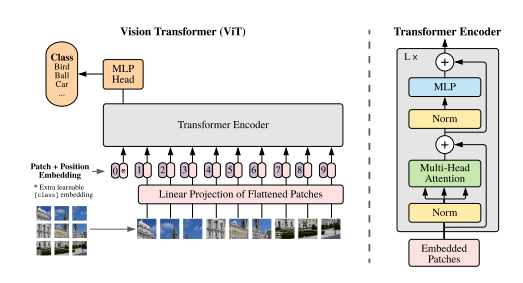

### 2-D Positional Embedding

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, imgSize, patchSize, embedDim, channels=3):
    super(PatchEmbedding, self).__init__()

    assert imgSize % patchSize == 0, "Patch Dimensions should be divisible by Image Dimensions"

    self.imgSize = imgSize
    self.patchSize = patchSize
    self.nPatches = (self.imgSize * self.imgSize)// (self.patchSize * self.patchSize)

    self.proj = nn.Conv2d(channels, embedDim, kernel_size=patchSize, stride=patchSize)

  def forward(self, x):
    x = self.proj(x)
    x = x.flatten(2)
    x = x.transpose(1, 2)

    return x

### Multi-Head Attention

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, dim, numHeads, qkv_bias=True, attnP=0, projP=0):
    super(MultiHeadAttention, self).__init__()

    self.numHeads = numHeads
    self.dim = dim
    self.headDim = dim // numHeads
    self.scale = self.headDim ** -0.5

    self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
    self.attnDrop = nn.Dropout(attnP)
    self.proj = nn.Linear(dim, dim)
    self.projDrop = nn.Dropout(projP)

  def forward(self, x):
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.numHeads, self.headDim).permute(2, 0, 3, 1, 4)
    Q, K, V = qkv[0], qkv[1], qkv[2]

    attention = (Q @ K.transpose(-1, -2)) * self.scale
    attention = attention.softmax(dim=-1)
    attention = self.attnDrop(attention)

    x = (attention @ V).transpose(1, 2).reshape(B, N, C)
    x = self.proj(x)
    x = self.projDrop(x)

    return x

### Multi-Layer Perceptron

In [ ]:
class MLP(nn.Module):
  def __init__(self, inFeatures, hiddenFeatures, outFeatures, dropout=0.1):
    super(MLP, self).__init__()

    self.fc1 = nn.Linear(inFeatures, hiddenFeatures)
    self.act = nn.GELU()
    self.fc2 = nn.Linear(hiddenFeatures, outFeatures)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = self.fc1(x)
    x = self.act(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.dropout(x)

    return x

### Block

* Combination of Multi-Head Attention and MLP
* Layer Normalization is done prior to Multi-Head Attention and MLP, unlike normal transformer

In [ ]:
class Block(nn.Module):
  def __init__(self, dim, nHeads, mlp_ratio=4.0, qkv_bias=True, projP=0., attnP=0.):
    super(Block, self).__init__()

    self.layerNorm1 = nn.LayerNorm(dim, eps=1e-6)
    self.attention = MultiHeadAttention(dim, nHeads, qkv_bias=qkv_bias, attnP = attnP, projP=projP)
    self.layerNorm2 = nn.LayerNorm(dim, eps=1e-6)

    hiddenFeatures = int(dim * mlp_ratio)

    self.mlp = MLP(
        inFeatures=dim,
        hiddenFeatures=hiddenFeatures,
        outFeatures=dim,
    )

  def forward(self, x):
    x = x + self.attention(self.layerNorm1(x))
    x = x + self.mlp(self.layerNorm2(x))

    return x

### Vision-Transformer Assembly

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self, imgSize=256, patchSize=32, channels=3, n_classes=1000, embed_dim=768, depth=12,
                 nHeads=12, mlp_ratio=4., qkv_bias=True, p=0., attn_p=0.):
    super(VisionTransformer, self).__init__()

    self.patchEmbedding = PatchEmbedding(imgSize, patchSize, embed_dim, channels)
    self.clsToken = nn.Parameter(torch.zeros(1, 1, embed_dim))
    self.posToken = nn.Parameter(torch.zeros(1, 1 + self.patchEmbedding.nPatches, embed_dim))
    self.posDrop = nn.Dropout(p=p)

    self.blocks = nn.ModuleList([Block(embed_dim, nHeads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, projP=p, attnP=attn_p) for _ in range(depth)])

    self.layerNorm = nn.LayerNorm(embed_dim, eps=1e-6)
    self.head = nn.Linear(embed_dim, n_classes)

  def forward(self, x):
    B = x.shape[0]
    x = self.patchEmbedding(x)

    clsToken = self.clsToken.expand(B, -1, -1)

    x = torch.cat((clsToken, x), dim=1)
    x = x + self.posToken
    x = self.posDrop(x)

    for block in self.blocks:
      x = block(x)

    x = self.layerNorm(x)
    x = x[:, 0]
    x = self.head(x)

    return x

## Model

### Model-Configuration

In [27]:
imgSize = 32
patchSize=32
channels=3
n_classes=10
embed_dim=128
depth=2
nHeads=2
mlp_ratio=2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionTransformer(imgSize=imgSize, patchSize=patchSize, channels=channels, n_classes=n_classes, embed_dim=embed_dim, depth=depth, nHeads=nHeads, mlp_ratio=mlp_ratio).to(device)

In [28]:
print(model)

VisionTransformer(
  (patchEmbedding): PatchEmbedding(
    (proj): Conv2d(3, 128, kernel_size=(32, 32), stride=(32, 32))
  )
  (posDrop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-1): 2 x Block(
      (layerNorm1): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (qkv): Linear(in_features=128, out_features=384, bias=True)
        (attnDrop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (projDrop): Dropout(p=0.0, inplace=False)
      )
      (layerNorm2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=128, out_features=256, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=256, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (layerNorm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_feat

Dataset and DataLoader

In [29]:
epochs = 10
batchSize = 128
lr = 1e-3

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainDataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainLoader = DataLoader(trainDataset, batchSize, shuffle=True, num_workers=2)

totalBatches = len(trainLoader)

Files already downloaded and verified


In [30]:
print("DataLoader Dimensions : ", trainLoader.dataset.data.shape)
print("Total Batches : ", totalBatches)

DataLoader Dimensions :  (50000, 32, 32, 3)
Total Batches :  391


In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
  model.train()

  totalLoss = 0
  correctPredictions = 0
  totalPredictions = 0

  batchBar = tqdm(trainLoader, desc=f"Epoch : [{epoch + 1}/{epochs}]", unit="batch")
  for i, data in enumerate(batchBar):
    images, labels = data

    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    totalLoss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    totalPredictions += labels.size(0)
    correctPredictions += (predicted == labels).sum().item()

    batchBar.set_postfix(Loss=loss.item())

print("Training Complete!", end="\n\n")

torch.save(model.state_dict(), "ViT_model.pth")

Epoch : [10/10]: 100%|██████████| 391/391 [00:40<00:00,  9.54batch/s, Loss=1.17]

Training Complete!

